In [1]:
import os, random, shutil
from os import walk
import numpy as np
import argparse
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. Define the model architecture

In [2]:
class Net(nn.Module):
    """Define the model architecture.
    """
    def __init__(self):
        super(Net,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            
        )
        self.full_connection=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(36864,120),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,15),
            nn.LogSoftmax(dim=1)
        )
               
    def forward(self,x):
        size = x.size(0)
        x = self.feature_extraction(x)
        x = x.view(size,-1)
        x = self.full_connection(x)
        return x

## 2. Get Training and Validation DataSet

In [3]:
def make_directory(train_data_dir,new_dir):
    """Define the data directory
    """
    directories=os.listdir(train_data_dir)
    for directory in directories:
        for c in ['train','valid']:
            path = new_dir + '/' + c + '/' + directory
            if not os.path.exists(path):
                os.makedirs(path)

def divide_train_validation(train_data_dir,new_dir):
    """Get the data into corresponding directory
    """
    class_names = os.listdir(train_data_dir)
    for classes in class_names:
        name = os.listdir(os.path.join(train_data_dir, classes))
        random.shuffle(name)
        training = name[0:int(0.9 * len(name))]
        validation = name[int(0.9 * len(name)):]
        for pic in training:
            shutil.copyfile(train_data_dir + '/' + classes + '/' + pic, new_dir+ '/train/' + classes + '/' + pic)
        for pic in validation:
            shutil.copyfile(train_data_dir + '/' + classes + '/' + pic, new_dir+ '/valid/' + classes + '/' + pic)

## 3. Training the model

In [4]:
def get_data(data_dir,c):
    """Transform the data in DataLoader format

    Arguments:
        data_dir (str):     The directory of training data

    Return:
        data (DataLoader):  The data in DataLoader format
    """
    if c=='val':
        transform = transforms.Compose([transforms.RandomCrop(200),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
        data = datasets.ImageFolder(data_dir, transform)
    if c=='train':
        transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(200),
                                    transforms.ToTensor(),
                                 transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=(254/255, 0, 0)),
                                   transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
        data = datasets.ImageFolder(data_dir, transform)
    return DataLoader(dataset=data, batch_size=16, shuffle=True)


def val(model,test_dir):
    """Test model performance on validation dataset.

    Arguments:
        train_data_dir (str):   The directory of training data
        model_dir (str):        The directory of the saved model.

    Return:
        validation_accuracy (float): The training accuracy.
    """
    test_loader = get_data(test_dir,'val')
    global val_acc
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    loss_fn = nn.NLLLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data,target = Variable(data),Variable(target)
            output = model(data)
            loss = loss_fn(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avg_loss = test_loss / len(test_loader)
        print('Validation Dataset')
        print('Average Loss:{:.4f} Accuracy:{:.4f}\n'.format(avg_loss,acc))
    val_acc.append(acc)
    return acc


def training(train_dir,test_dir,model_dir):
    """Main training model.

    Arguments:
        train_data_dir (str):   The directory of training data
        model_dir (str):        The directory of the saved model.

    Return:
        train_accuracy (float): The training accuracy.
    """
    global train_acc
    train_loader = get_data(train_dir,'train')
    model = Net()
    best_acc=0
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=0)
    for epoch in range(100):
        print('************** Epoch {} **************'.format(epoch + 1))
        total_loss = 0
        correct = 0
        total_num = len(train_loader.dataset)
        for batch_id, (data, target) in enumerate(train_loader):
            data,target = Variable(data),Variable(target)
            pred = model(data)
            loss = loss_fn(pred,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print_loss = loss.data.item()
            total_loss += print_loss
            _, pred = torch.max(pred.data, 1)
            correct += torch.sum(pred == target)
            # print training information
            if (batch_id + 1) % 30 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss:{:.4f}'.format((batch_id + 1) * len(data), len(train_loader.dataset),
                                                              100. * (batch_id + 1) / len(train_loader), loss.item()))
                
        # calculate average loss
        avg_loss = total_loss / len(train_loader)
        # calculate accuracy
        correct = correct.data.item()
        acc = correct / total_num
        print('\nTraining Dataset')
        print('Average Loss:{:.4f} Accuracy:{:.4f}'.format(avg_loss, acc))
        train_acc.append(acc)
        # check the performance on validation dataset
        print('Validation Dataset')
        vcc = val(model,test_dir)
        if vcc > best_acc:
            best_acc = vcc
            torch.save(model, model_dir)

In [5]:
train_acc, val_acc = [],[]
train_dir = './data/train/'
real_dir = './data_train_valid'
make_directory(train_dir, real_dir)
divide_train_validation(train_dir, real_dir )
training(real_dir+'/train', real_dir+'/valid', 'trained_cnn.pth')

************** Epoch 1 **************
[480/1350 (35%)]	Loss:2.6954
[960/1350 (71%)]	Loss:2.6685

Training Dataset
Average Loss:2.7028 Accuracy:0.0763
Validation Dataset
Validation Dataset
Average Loss:2.6651 Accuracy:0.0667

************** Epoch 2 **************
[480/1350 (35%)]	Loss:2.6655
[960/1350 (71%)]	Loss:2.6098

Training Dataset
Average Loss:2.5963 Accuracy:0.1519
Validation Dataset
Validation Dataset
Average Loss:2.5463 Accuracy:0.1867

************** Epoch 3 **************
[480/1350 (35%)]	Loss:2.5961
[960/1350 (71%)]	Loss:2.4058

Training Dataset
Average Loss:2.4510 Accuracy:0.1822
Validation Dataset
Validation Dataset
Average Loss:2.4140 Accuracy:0.2200

************** Epoch 4 **************
[480/1350 (35%)]	Loss:2.2733
[960/1350 (71%)]	Loss:2.7124

Training Dataset
Average Loss:2.3559 Accuracy:0.2252
Validation Dataset
Validation Dataset
Average Loss:2.2798 Accuracy:0.2533

************** Epoch 5 **************
[480/1350 (35%)]	Loss:2.1228
[960/1350 (71%)]	Loss:2.1799

Tra

[960/1350 (71%)]	Loss:0.8709

Training Dataset
Average Loss:0.8940 Accuracy:0.6800
Validation Dataset
Validation Dataset
Average Loss:1.3546 Accuracy:0.5933

************** Epoch 38 **************
[480/1350 (35%)]	Loss:0.6441
[960/1350 (71%)]	Loss:1.1253

Training Dataset
Average Loss:0.8758 Accuracy:0.6904
Validation Dataset
Validation Dataset
Average Loss:1.2914 Accuracy:0.6133

************** Epoch 39 **************
[480/1350 (35%)]	Loss:0.6116
[960/1350 (71%)]	Loss:1.0889

Training Dataset
Average Loss:0.8557 Accuracy:0.6993
Validation Dataset
Validation Dataset
Average Loss:1.4314 Accuracy:0.5667

************** Epoch 40 **************
[480/1350 (35%)]	Loss:1.5216
[960/1350 (71%)]	Loss:0.8963

Training Dataset
Average Loss:0.9467 Accuracy:0.6704
Validation Dataset
Validation Dataset
Average Loss:1.3881 Accuracy:0.6200

************** Epoch 41 **************
[480/1350 (35%)]	Loss:1.1214
[960/1350 (71%)]	Loss:0.5966

Training Dataset
Average Loss:0.8313 Accuracy:0.7156
Validation Da

Validation Dataset
Average Loss:1.6903 Accuracy:0.6333

************** Epoch 74 **************
[480/1350 (35%)]	Loss:0.3116
[960/1350 (71%)]	Loss:0.3221

Training Dataset
Average Loss:0.5804 Accuracy:0.7941
Validation Dataset
Validation Dataset
Average Loss:1.6119 Accuracy:0.5800

************** Epoch 75 **************
[480/1350 (35%)]	Loss:0.7215
[960/1350 (71%)]	Loss:0.1971

Training Dataset
Average Loss:0.5513 Accuracy:0.8096
Validation Dataset
Validation Dataset
Average Loss:1.9458 Accuracy:0.6000

************** Epoch 76 **************
[480/1350 (35%)]	Loss:0.7905
[960/1350 (71%)]	Loss:0.6232

Training Dataset
Average Loss:0.5691 Accuracy:0.8022
Validation Dataset
Validation Dataset
Average Loss:1.5526 Accuracy:0.6400

************** Epoch 77 **************
[480/1350 (35%)]	Loss:0.4651
[960/1350 (71%)]	Loss:0.4188

Training Dataset
Average Loss:0.5459 Accuracy:0.8207
Validation Dataset
Validation Dataset
Average Loss:1.5183 Accuracy:0.6533

************** Epoch 78 **************
[

## 4. Plot the accuracy

In [6]:
from matplotlib.ticker import MaxNLocator

def plot_acc(train_acc,val_acc):  
    """Plot the accuracy changes.
    """
    ax = plt.figure(1) 
    le = len(train_acc)
    x = [i for i in range(1,le+1)]
    l1, =plt.plot(x, train_acc, 'bo-') 
    l2, =plt.plot(x, val_acc, 'ro-')
    plt.legend(handles=[l1,l2],labels=['train_acc','val_acc'],loc='best')
    plt.title('Accuracy on Training and Validation Dataset')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show() 

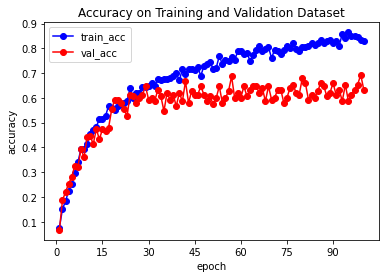

In [7]:
plot_acc(train_acc,val_acc)